# Astr 257 HR Diagram, Aditya Sengupta

In [1]:
!which python

/Users/adityasengupta/opt/anaconda3/envs/astr257/bin/python


In [2]:
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import SigmaClip
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt
import numpy as np
from os import path
from photutils.background import MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import BasicPSFPhotometry, DAOGroup, IntegratedGaussianPRF

In [3]:
datapath = "../../../Project 2--HR Diagram/data/"
sigma_clip = SigmaClip(sigma=3.0)
getlims = ZScaleInterval().get_limits

def view_as_ds9(img, **kwargs):
    vmin, vmax = getlims(img)
    if vmin > vmax:
        vmin, vmax = vmax, vmin
    plt.imshow(img, vmin=vmin, vmax=vmax, **kwargs)

def fname_to_data(fname, calib):
    return np.dstack([fits.open(path.join(datapath, calib, fname + str(i) + ".fits"))[0].data for i in range(3)]).astype(np.float64)

darks, biases, flatsB, flatsV = map(lambda x: fname_to_data(x, "calibration"), ["dark", "bias", "flatB", "flatV"])
landBs, landVs, ngcBs, ngcVs = map(lambda x: fname_to_data(x, "ngc 6819"), ["land_b", "land_v", "ngc_b", "ngc_v"])

In [4]:
med_dark, med_bias, med_flatB, med_flatV = map(lambda x: np.nanmedian(x, axis=2), [darks, biases, flatsB, flatsV])
med_dark = med_dark - med_bias
med_flatB = med_flatB - med_bias
med_flatV = med_flatV - med_bias

mediandiv = lambda x: x / np.nanmedian(x)

corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs = [np.zeros_like(x) for x in [landBs, landVs, ngcBs, ngcVs]]
denomB = mediandiv(med_flatB - med_dark / 2)
denomV = mediandiv(med_flatV - med_dark / 6)
denomB[np.where(denomB == 0)] = 1
denomV[np.where(denomV == 0)] = 1
for i in range(3):
    corr_landBs[:,:,i] = ((landBs[:,:,i] - med_bias) - med_dark / 2) / denomB
    corr_landVs[:,:,i] = ((landVs[:,:,i] - med_bias) - med_dark / 6) / denomV
    corr_ngcBs[:,:,i] = ((ngcBs[:,:,i] - med_bias) - med_dark / 2) / denomB
    corr_ngcVs[:,:,i] = ((ngcVs[:,:,i] - med_bias) - med_dark / 6) / denomV

landB, landV, ngcB, ngcV = map(lambda x: np.nanmedian(x, axis=2), [corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs])

checking exposure times here

`fits.open(path.join(datapath, "ngc 6819", "ngc_v0.fits"))[0].header['EXPTIME'] # etc`

darks were 60 seconds

biases were 0 seconds (obv)

flatsB were 30 seconds

flatsV were 10 seconds

landB were 60 seconds

landV were 60 seconds

ngcB were 60 seconds

ngcV were 60 seconds

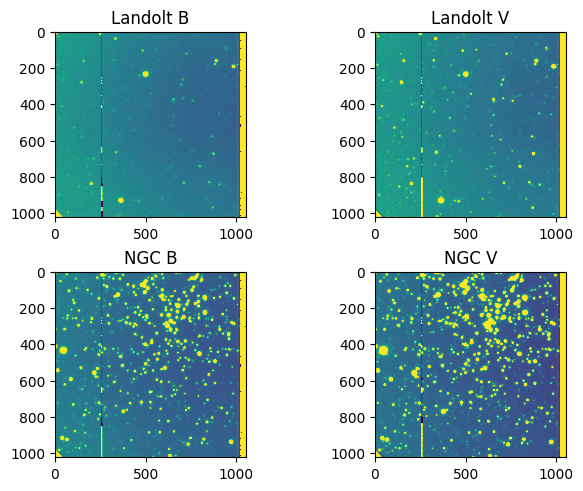

In [5]:
mosaic="AB;CD"
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [landB, landV, ngcB, ngcV], ["Landolt B", "Landolt V", "NGC B", "NGC V"]):
    vmin, vmax = getlims(d)
    im = ax_dict[pos].imshow(d, vmin=vmin, vmax=vmax)
    ax_dict[pos].set_title(n)
    # plt.colorbar(im, ax=ax_dict[pos])

segmentation map - image with a mask for every object it's identified

looks like splotches on a canvas, one splotch per source

overlay with origin image


In [6]:
fix = lambda img: np.delete(img[:, :990], 256, 1)
if ngcB.shape[1] == 1056:
    ngcB, ngcV, landB, landV = map(fix, [ngcB, ngcV, landB, landV])

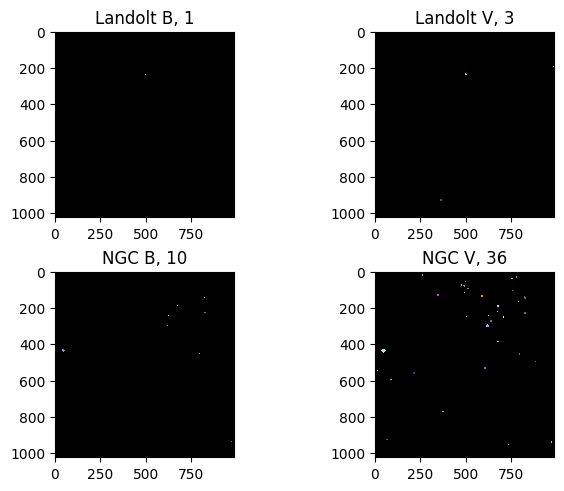

In [7]:
from photutils.segmentation import detect_sources
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)
for (pos, d, n) in zip(['A', 'B', 'C', 'D'], [landB, landV, ngcB, ngcV], ["Landolt B", "Landolt V", "NGC B", "NGC V"]):
    seg_i = detect_sources(d, threshold=3000, npixels=9)
    im = ax_dict[pos].imshow(seg_i, cmap=seg_i.cmap, interpolation='nearest')
    ax_dict[pos].set_title(f"{n}, {seg_i.nlabels}")
    # plt.colorbar(im, ax=ax_dict[pos])

In [55]:
photometry = BasicPSFPhotometry(
    group_maker = DAOGroup(crit_separation=3),
    bkg_estimator = MedianBackground(sigma_clip),
    psf_model = IntegratedGaussianPRF(),
    fitshape = 51,
    finder = DAOStarFinder(threshold=200, fwhm=(3.26)), # tune fwhm based on seeing - 1.2 arcsec in px. Measurable with ds9/by eye 
    fitter = LevMarLSQFitter()
)

In [56]:
landB_phot = photometry(landB - 120)
print(f"Identified {len(landB_phot)} stars in the Landolt field.");

Identified 9 stars in the Landolt field.


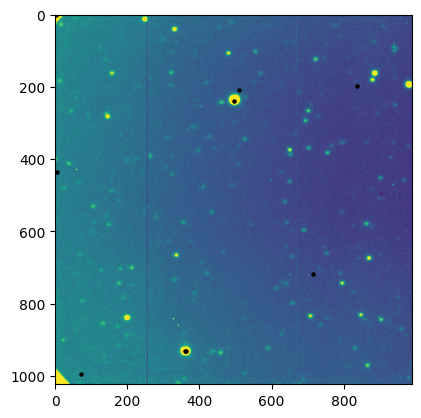

In [57]:
view_as_ds9(landB)
plt.scatter(landB_phot['x_fit'], landB_phot['y_fit'], s=5, c='k')

In [58]:
landB_phot = photometry(landB)
landV_phot = photometry(
    landV, 
    init_guesses = Table(
        names=['x_0', 'y_0'], 
        data = [landB_phot['x_fit'], landB_phot['y_fit']]
    )
)

print(f"Identified {len(landB_phot)} stars in the Landolt field.")

# view_as_ds9(landV - photometry.get_residual_image())

Identified 9 stars in the Landolt field.


In [59]:
ngcB_phot = photometry(ngcB)
ngcV_phot = photometry(
    ngcV, 
    init_guesses = Table(
        names=['x_0', 'y_0'], 
        data = [ngcB_phot['x_fit'], ngcB_phot['y_fit']]
    )
)

print(f"Identified {len(ngcB_phot)} stars in the target field.")
# view_as_ds9(ngcV - photometry.get_residual_image())

Identified 48 stars in the target field.


In [60]:
refstar_idx = np.argmin((landB_phot['x_fit'] - 498) ** 2 + (landB_phot['y_fit'] - 237) ** 2)
landB_flux = landB_phot[refstar_idx]["flux_fit"] / 60
landV_flux = landV_phot[refstar_idx]["flux_fit"] / 60
landV_mag, landB_mag = 12.388, 12.783
zp_B = -2.5 * np.log10(1 / landB_flux) + landB_mag
zp_V = -2.5 * np.log10(1 / landV_flux) + landV_mag
mag_B = -2.5 * np.log10(ngcB_phot["flux_fit"] / 60 / landB_flux) + zp_B
mag_V = -2.5 * np.log10(ngcV_phot["flux_fit"] / 60 / landV_flux) + zp_V

In [61]:
print(zp_B, zp_V)

20.095748730225367 20.612629123233685


Text(0.5, 1.0, 'Hertzsprung-Russell diagram of NGC 6819')

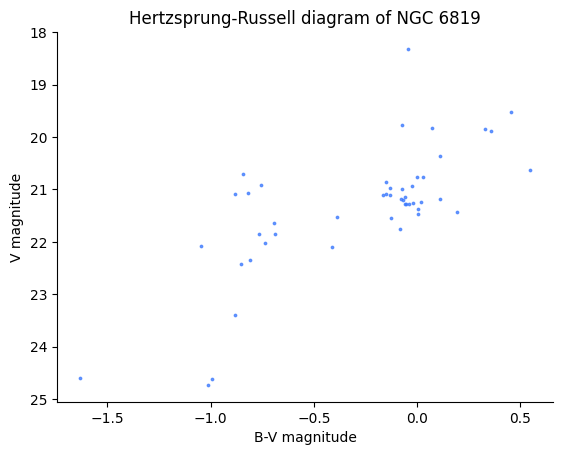

In [62]:
plt.scatter(mag_B - mag_V, mag_V, s=3, c='xkcd:lightish blue', alpha=0.75)
plt.xlabel("B-V magnitude")
plt.ylabel("V magnitude")
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Hertzsprung-Russell diagram of NGC 6819")